# Beer Reviews NLP

In this notebook I am going to do some basic natural language processing on beer reviews. The main question to be answered is a fairly simple one. What are the most frequent descriptors, i.e. words that describe the taste, aroma, look, etc. of a beer, for the most popular beers. To answer this question I will be getting beer reviews for the 100 most rated beers on beeradvocate.com. To limit the amount of data to go through I will check out the 1000 most recent ratings for each beer (note that not all ratings include reviews so it will be significantly less than 1000 reviews for each beer).

This analysis may give us some insight into what flavors or aromas people like most in their beer. But, I think a more interesting potential use of such an analysis is to try to figure out what flavor combinations haven't been used yet. There seems to always be a lot of demand for something new and different from craft beer drinkers. For example, check out this [article](https://www.forbes.com/sites/taranurin/2019/01/09/a-new-flagshipfebruary-campaign-aims-to-save-core-beer-brands-before-they-disappear/#e361fec50587) or this [article](https://vinepair.com/articles/hop-take-flagship-beers-failing/). So, ideally we could take popular flavors that haven't yet been combined in some interesting way and develop beers to fill that gap. Of course we would need to look at a lot more data than the 100 most popular beers to do this, but hopefully this notebook will show a bigger project would be worthwhile.  

In [1]:
# Import required packages
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [2]:
# Get 100 Most Popular Beers
popular_beers_url = requests.get('https://www.beeradvocate.com/lists/popular/').text
popular_beer = BeautifulSoup(popular_beers_url, 'lxml')

# Get Beers, Number of Reviews and Scores
beer_list = [i.get_text() for i in popular_beer.find_all('b')]
beer_list = beer_list[2:]

top_beers = []
for i in range(0, 100):
    x = 3*i
    x = beer_list[x:(x+3)]
    top_beers.append(x)
    
# Get Breweries and Style for Beers
breweries_and_style_data = [i.contents for i in popular_beer.find_all('span', {'class' : 'muted'})]

breweries_list = []
for i in range(1,101):
    x = breweries_and_style_data[i][1].contents
    breweries_list.append(x)
breweries_list = [i[0] for i in breweries_list]

beer_style_list = []
for i in range(1,101):
    x = breweries_and_style_data[i][3].contents
    beer_style_list.append(x)
beer_style_list = [i[0] for i in beer_style_list]

# Get links to top 100 beers
beer_links = [i.get('href') for i in popular_beer.find_all('a')]
beer_links = [i for i in beer_links if type(i) == str and len(i)>7 and i[:7] == '/beer/p']
beer_links = beer_links[:200:2]
beer_links = ['https://www.beeradvocate.com'+i for i in beer_links]

In [3]:
# Make dataframe for data
df = pd.DataFrame(top_beers, columns = ['Beer Name', 'Number of Ratings', 'Score'])
df['Brewery'] = breweries_list
df['Style'] = beer_style_list
df['Link'] = beer_links
df.head()

,Beer Name,Number of Ratings,Score,Brewery,Style,Link
0,Breakfast Stout,"17,331",4.51,Founders Brewing Company,American Imperial Stout,https://www.beeradvocate.com/beer/profile/1199...
1,90 Minute IPA,"16,072",4.27,Dogfish Head Craft Brewery,American Imperial IPA,https://www.beeradvocate.com/beer/profile/64/2...
2,Two Hearted Ale,"15,076",4.27,Bell's Brewery - Eccentric Café & General Store,American IPA,https://www.beeradvocate.com/beer/profile/287/...
3,Pliny The Elder,"15,057",4.64,Russian River Brewing Company,American Imperial IPA,https://www.beeradvocate.com/beer/profile/863/...
4,Heady Topper,"14,454",4.71,The Alchemist,New England IPA,https://www.beeradvocate.com/beer/profile/4631...


In [4]:
# Code to Scrape Reviews !IMPORTANT NOTE!: Running this code will take approximately an hour
'''
for beer in df.index:
    
    #Make List of Links to Scrape
    first_thou = [i*25 for i in range(40)]
    first_thou_links = [df.Link[beer]+'?view=beer&sort=&start={}'.format(i) for i in first_thou]

    #Scrape Reviews and Store in List
    review_text = []
    for j in first_thou_links:
        source = requests.get(j).text
        soup = BeautifulSoup(source, 'lxml')
        reviews = [i.get_text('\n').split('\n') for i in soup.find_all(id ='rating_fullview_content_2')]
        for i in reviews:
            if i[2][-1] == '%':
                x = [i[3]]
            elif len(i) == 7:
                x = [i[4]]
            else:
                x = [i[4]] + i[5:-4]
            review_text.append(x)
    
    #Write Reviews to text file
    beer_name = df['Beer Name'][beer].replace(' ', '_')
    with open('Beer_Reviews/{}.txt'.format(beer_name), 'w', encoding='UTF-8') as f:
        for l in review_text:
            for i in l:
                f.write(i+' ')
            f.write('\n')   
'''

"\nfor beer in df.index:\n    \n    #Make List of Links to Scrape\n    first_thou = [i*25 for i in range(40)]\n    first_thou_links = [df.Link[beer]+'?view=beer&sort=&start={}'.format(i) for i in first_thou]\n\n    #Scrape Reviews and Store in List\n    review_text = []\n    for j in first_thou_links:\n        source = requests.get(j).text\n        soup = BeautifulSoup(source, 'lxml')\n        reviews = [i.get_text('\n').split('\n') for i in soup.find_all(id ='rating_fullview_content_2')]\n        for i in reviews:\n            if i[2][-1] == '%':\n                x = [i[3]]\n            elif len(i) == 7:\n                x = [i[4]]\n            else:\n                x = [i[4]] + i[5:-4]\n            review_text.append(x)\n    \n    #Write Reviews to text file\n    beer_name = df['Beer Name'][beer].replace(' ', '_')\n    with open('Beer_Reviews/{}.txt'.format(beer_name), 'w', encoding='UTF-8') as f:\n        for l in review_text:\n            for i in l:\n                f.write(i+' '

In [5]:
# Make beer review text files into nltk corpus
corpus_root = 'Beer_Reviews'
wordlists = PlaintextCorpusReader(corpus_root, '.*')

Now that we have a corpus of beer reviews we can go about answering the main question, i.e. what are the most common descriptive words used in reviews of the 100 most popular beers. To answer this we will need to filter out the non-descriptive words and then get counts of the words we have remaining. But first, I want to estimate how many reviews there are. Since the ratings are a fixed length, we should be able to filter those out and just keep the ratings that include reviews. Then we can count up how many we have left.

In [6]:
# Each rating/review is on a new line so we can split the raw text by lines to seperate them
raw_rating_list = wordlists.raw().split('\n')
raw_rating_list[:5]

['look: 4 | smell: 3.75 | taste: 4 | feel: 3.75 | overall: 3.75 Can’t believe the low ratings here. It is a unique floraly taste but very delightful. Not real hoppy so that may be the reason but a solid tasteful PA. \xa0 \r',
 'look: 3.75 | smell: 3.25 | taste: 3 | feel: 3.25 | overall: 3.25 Medium light body with a very mild aroma. Theres apricot, some grass, and malt but aroma is mostly apricot.   Taste is a little dry, as well as tasting like dried apricots and just a bit sweet.  Not bad but also not too memorable \xa0 \r',
 'look: 3.5 | smell: 2.5 | taste: 3 | feel: 3.5 | overall: 3.25 \r',
 'look: 3.75 | smell: 3 | taste: 3.5 | feel: 3.5 | overall: 3.5 When I opened the bottle, the beer smelled bad, like it was old. The taste was bitter . I liked all the other Magic Hat beers I have tried but this one was a real disappointment. \xa0 \r',
 'look: 3.75 | smell: 3.75 | taste: 3.75 | feel: 3.5 | overall: 3.75 Pours to a cooper hue, but head and lacing disappear to quickly. Has an inte

Here we have a list of the ratings and we need to filter out ratings that don't include a review, the third rating is an example of one we want to filter out. The rating can vary in length because the scores can have different lengths. But, anything longer than 70 characters long should include a review.

In [7]:
# Filter out ratings with no review
raw_review_list = [i for i in raw_rating_list if len(i)>70]
len(raw_review_list)

23026

So out of 100,000 ratings it looks like a bit less that a quarter include reviews. Now we can turn our attention to getting the frequency for the descriptors. Since we are only interested in descriptors we can start by filtering out words we do not want.  

In [8]:
# Get list of stop words and make list of words used in the rating of the beers (which will by far be the most common words in the corpus)
stop_words = set(stopwords.words('english')) 
rate_words = ['taste','smell','feel','overall','look']

# Filter them out
filter_words = [i.lower() for i in wordlists.words() if i.isalpha() and (not i.lower() in stop_words) and (not i.lower() in rate_words)]

In [9]:
# Standardize words
lemmatizer = nltk.WordNetLemmatizer()
review_words = [lemmatizer.lemmatize(i) for i in filter_words]

In [10]:
# Get list to filter any words that are not adjectives, adverbs, or nouns 
pos_tuples = nltk.pos_tag(set(review_words))
pos_wanted = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'NN', 'NNS', 'VBP']
pos_wanted_words = []
for i in pos_tuples:
    if i[1] in pos_wanted:
        pos_wanted_words.append(i[0])
'''note: I have also included verbs because it turns out this POS tagger marks 'chocolate' as a verb, it may be worth trying other POS taggers'''

In [11]:
# Filter words and make word frequency dictionary 
words_of_interest = [i for i in review_words if i in pos_wanted_words]
fdist = nltk.FreqDist(words_of_interest)

# Make a list of top 100 to make it sortable
top_100_words = [(k,v) for k,v in fdist.items() if v>sorted(list(fdist.values()), reverse=True)[101]]

Now that we have our word counts, let's see what the most frequent words are.

In [12]:
# Check out the top 30
sorted(top_100_words, reverse=True, key=lambda tup: tup[1])[:30]

[('beer', 20950),
 ('head', 12544),
 ('hop', 10635),
 ('malt', 10567),
 ('flavor', 8787),
 ('good', 8265),
 ('dark', 8261),
 ('nice', 7490),
 ('sweet', 6974),
 ('light', 6391),
 ('aroma', 6367),
 ('chocolate', 5976),
 ('well', 5852),
 ('carbonation', 5684),
 ('finish', 5591),
 ('great', 5454),
 ('bottle', 5351),
 ('medium', 5247),
 ('ipa', 5193),
 ('coffee', 5126),
 ('note', 4892),
 ('color', 4823),
 ('pours', 4782),
 ('little', 4702),
 ('glass', 4662),
 ('citrus', 4660),
 ('smooth', 4619),
 ('bit', 4590),
 ('caramel', 4571),
 ('bitter', 4562)]

Most of this is to be expected. Clearly, we didn't filter out of everything that isn't of interest but there are several descriptors in this list of 30 terms and so we could gain some insight from it. For example, I am a little surpised to see chocolate and coffee are more frequent than citrus and caramel. I would associate chocolate and coffee mainly with stouts, whereas citrus and caramel would be associated more with pale ales. 

In [13]:
stouts = [i for i in df.Style.values if 'Stout' in i]
pale_ales = [i for i in df.Style.values if 'IPA' in i or 'Pale Ale' in i]
display(len(stouts), len(pale_ales))

20

38

Of the top 100 most rated beers, around 20 are stouts and around 38 are pale ales. Of course we pulled the same number of ratings for each beer, not reviews, so it may be that stouts are just reviewed more frequently even if they are on the whole a bit less popular. If we wanted to draw a conclusion then we would want to check on this. Of course, we could construct the text documents to have a standard number of reviews (perhaps I will do this next time).

It is not surprising though to see that malt is one of the most common descriptors as it is one of the main ingredients of beer. Of course, malts can have a variety of flavors, so the term malt on its own isn't as informative as it would be if we had it in context. There are a couple ways to try to get some context. First, we can apply the concordance method to the review text for the term 'malt'. Then I will generate the bigrams for the term malt and get the frequency distribution for them. 

In [14]:
# the nltk text object has useful methods
review_text = nltk.text.Text(wordlists.words())
review_text.concordance('malt')

Displaying 25 of 25 matches:
a . Theres apricot , some grass , and malt but aroma is mostly apricot . Taste i
 a hint of apricot . Tastes of bready malt with just a faint fruitness , finishe
s faintly of fruit , tastes mainly of malt and a little fruity sweetness . Not m
e white head of bubbly foam . Smell : Malt , some citrus and fruitiness , and a 
fruity , almost like juice mixed with malt liquor . Balanced by hop bitterness a
focus on the apricot and some caramel malt sweetness without much in the way of 
thing I tasted was apricot and bready malt with some sweet vanilla or caramel . 
weet , a faint hint of caramel , thin malt towards the end with a tart aftertast
ot , so it ends up tasting like a bad malt soda . A brew of historical interest 
th minimal head . Smells of fruit and malt . Taste is fruity up front with hints
: 3 . 75 | overall : 3 . 75 Smells of malt mostly with some faint fruity sweet s
tasting some fruit along with a solid malt backbone with just the hint of hop bi

In [15]:
malt_bigrams = [i for i in nltk.bigrams(words_of_interest) if i[1] == 'malt']
malt_bigram_fdist = nltk.FreqDist(malt_bigrams)

In [16]:
malt_bigram_fdist

FreqDist({('caramel', 'malt'): 900, ('sweet', 'malt'): 890, ('bready', 'malt'): 382, ('hop', 'malt'): 340, ('dark', 'malt'): 333, ('chocolate', 'malt'): 327, ('coffee', 'malt'): 177, ('aroma', 'malt'): 165, ('light', 'malt'): 140, ('nice', 'malt'): 133, ...})

One last thing I want to check on regarding the most frequent descriptors is how often the word 'good' is preceded by a negation. This could be an issue with any of the words, but while it would be somewhat unusual to describe a beer as not malty in a review, it wouldn't be odd at all to describe a beer as not good.  

In [17]:
not_good = re.compile(r'not\sgood|not\svery\sgood|not\sso\sgood|not\sthat\sgood').findall(wordlists.raw())
len(not_good)

49

While we found some instances of 'not good', and there are presumably more we didn't find, it appears unlikely to be a signifcant amount when compared to the total number.

Now that we have answered the main question, there are a couple other things I want to check out. First let's look at the most common word pairs. 

In [18]:
review_text.collocations()

white head; tan head; pint glass; brown sugar; dark chocolate; dark
brown; roasted malts; dark fruit; well balanced; amber color; roasted
malt; dark fruits; Sierra Nevada; 12oz bottle; dry finish; west coast;
taste feel; smell taste; imperial stout; taste overall


We saw above that 'dark' is a word very frequently used in reviews. Here we can see that it is often used in describing the taste of the beer and not just its appearance.

Now I want to get a look at what fruit flavors or aromas are most common. To do this we will need to generate a list of fruit names, which I will do by using WordNet. 

In [19]:
# Get all edible fruit hyponyms (I'll go two levels deep, more may be advisable)
fruit_hypo_list = []
for i in wn.synset('edible_fruit.n.01').hyponyms():
    fruit_hypo_list.append(i)
    for j in i.hyponyms():
        fruit_hypo_list.append(j)

In [20]:
# Get names of fruit hyponyms
fruit_names = []
for i in fruit_hypo_list:
    for lemma in i.lemmas():
        fruit_names.append(lemma.name())

# Get fruits in reviews
fruits_in_reviews = [i for i in words_of_interest if i in fruit_names]

# Get frequency counts of fruit words
fruit_dist = nltk.FreqDist(fruits_in_reviews)

In [21]:
fruit_dist

FreqDist({'citrus': 4660, 'orange': 3736, 'grapefruit': 2566, 'cherry': 1185, 'raisin': 1064, 'date': 993, 'banana': 935, 'lemon': 894, 'pineapple': 582, 'plum': 576, ...})

It looks like citrus is by far the most common fruit flavor/aroma. Let's plot the distribution of some of these terms in the review text using a lexical dispersion plot. Since the reviews for each beer are grouped together in the text, we should see some clusters of the fruit terms rather than an even distribution.

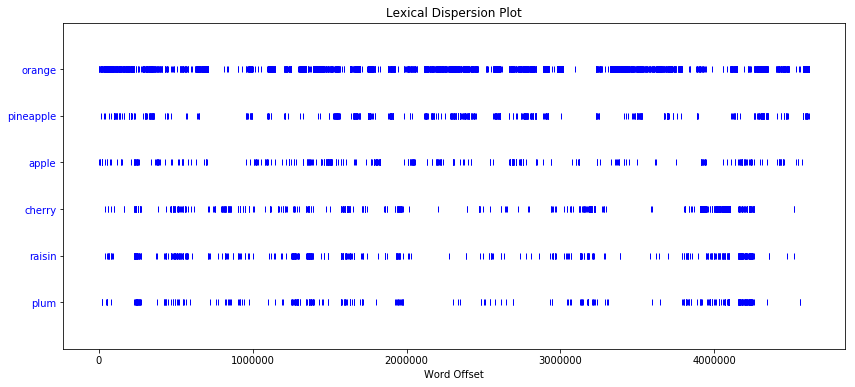

In [22]:
plt.figure(figsize=(14,6))
review_text.dispersion_plot(['orange', 'pineapple', 'apple', 'cherry', 'raisin', 'plum'])

Here we can see that raisin and plum flavors often appear together, while either rarely show up together with pineapple. Maybe it's time someone made a beer with notes of pineapple and plum.

#### Where to go from here...

Based on what we have seen, I do think it could be interesting to do a much more comprehensive study of beer reviews. Besides increasing the number of beers we consider, and perhaps also how many reviews we gather, I think next time I get review data I will try to do it in a way that we can analyze how word usage has changed over time. We may be able to track various trends in beer flavors for instance. 
